In [1]:
!pip install atmos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.4/381.4 kB 13.6 MB/s eta 0:00:00


In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33299")
client

<Client: 'tcp://127.0.0.1:33299' processes=8 threads=64, memory=235.96 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:44849' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
import gcm_filters
import gsw
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gs://meom-ige-scratch/roxyboy'

In [4]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [5]:
dss = cat.eNATL60(region='1',datatype='surface_hourly', season='fma'
                 ).to_dask()
dss.coords['day'] = ('time_counter',np.repeat(np.arange(len(dss.time_counter)//24),
                                              24))
dss = dss.groupby('day').mean('time_counter',skipna=True)

dss

<xarray.Dataset>
Dimensions:   (y: 763, x: 611, day: 89)
Coordinates: (12/14)
    depth     (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...        ...
    e2v       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lat       (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon       (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat   (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon   (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
  * day       (day) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    qt_oce    (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    somecrty  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sometauy  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sosaline  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sossheig  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    ...        ...
    sowaflup  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozocrtx  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozotaux  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    tmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    umask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    vmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>

In [6]:
dsi = cat.eNATL60(region='1',datatype='interior_daily', season='fma'
                 ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),
                                  depthu=slice(None,-1)
                                 ).chunk({'deptht':5,'depthw':5,
                                          'depthv':5,'depthu':5}
                                        )
dsi

<xarray.Dataset>
Dimensions:       (y: 763, x: 611, deptht: 106, depthu: 106, depthv: 106,
                   depthw: 107, time_counter: 89)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>

In [7]:
YC = dss.lat.mean('x')
XC = dss.lon.mean('y')
YG = xr.concat([YC[0]-YC.diff('y').min(skipna=True),
                .5*(YC[1:] + YC[:-1])
               ],'y')
XG = xr.concat([XC[0]-XC.diff('x').min(skipna=True),
                .5*(XC[1:] + XC[:-1])
               ],'x')

In [8]:
taux = xr.DataArray(dss.sozotaux.data, dims=['time','YC','XG'],
                    coords={'YC':YC.data,'XG':XG.data}
                   )
tauy = xr.DataArray(dss.sometauy.data, dims=['time','YG','XC'],
                    coords={'YG':YG.data,'XC':XC.data}
                   )
fwf  = xr.DataArray(dss.sowaflup.data, dims=['time','YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )
Q    = xr.DataArray(dss.qt_oce.data, dims=['time','YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )

In [9]:
v  = xr.DataArray(dsi.vomecrty.data, dims=['time','Z','YG','XC'],
                  coords={'Z':dsi.depthv.data,'YG':YG.data,'XC':XC.data}
                 )
u  = xr.DataArray(dsi.vozocrtx, dims=['time','Z','YC','XG'],
                  coords={'Z':dsi.depthu.data,'YC':YC.data,'XG':XG.data}
                 )
w  = xr.DataArray(dsi.vovecrtz.data, dims=['time','Zp1','YC','XC'],
                  coords={'Zp1':dsi.depthw.data,'YC':YC.data,'XC':XC.data}
                 )
CT = xr.DataArray(dsi.votemper.data, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )
SA = xr.DataArray(dsi.vosaline, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )

In [10]:
ds = CT.to_dataset(name='CT')
ds['SA'] = SA
ds['U'] = u
ds['V'] = v
ds['W'] = w
ds['taux'] = taux  # N/m2 = (kg.m/s2)/m2
ds['tauy'] = tauy  # N/m2
ds['Ffw'] = fwf    # kg/m2/s
ds['Q'] = Q        # W/m2 = (N.m/s)/m2 = (kg.m2/s3)/m2
ds['maskC'] = xr.DataArray(dsi.tmask.data, dims=['Z','YC','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XC':XC.data}
                          )
ds['maskW'] = xr.DataArray(dsi.umask.data, dims=['Z','YC','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XG':XG.data}
                          )
ds['maskS'] = xr.DataArray(dsi.vmask.data, dims=['Z','YG','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XC':XC.data}
                          )
ds['maskG'] = xr.DataArray(dsi.fmask.data, dims=['Z','YG','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XG':XG.data}
                          )

coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        "Z": {"center": "Z",  "outer":"Zp1"}
       }
grid = Grid(ds, periodic=[],
            coords=coords
           )
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> outer
  * outer    Zp1 --> center

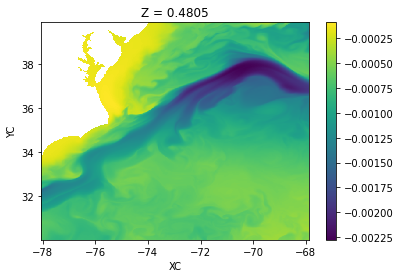

In [11]:
alpha = xr.apply_ufunc(gsw.alpha,  # 1/K
                       SA.isel(Z=0), CT.isel(Z=0), 0., 
                       dask='parallelized'
                      ) 
Cp = 1005.
rho_air = 1.225
grav = 9.81
B0 = grav*alpha * (ds.Q/rho_air/Cp)
B0.isel(time=0).plot()

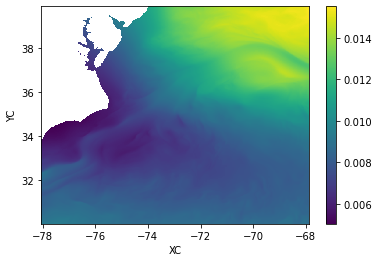

In [12]:
rho0 = 1000.
ustar = np.sqrt(np.sqrt(grid.interp(ds.taux**2,'X',boundary='extend') 
                        + grid.interp(ds.tauy**2,'Y',boundary='extend')
                       )
                / rho0)
ustar.isel(time=0).plot()

/tmp/ipykernel_419/3447563087.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  H = xr.DataArray(xr.open_zarr(gcs.get_mapper(


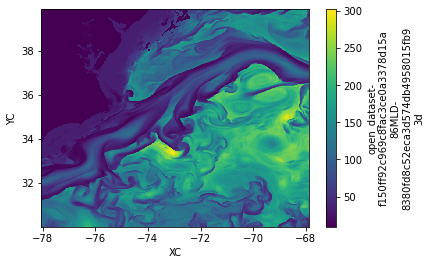

In [49]:
H = xr.DataArray(xr.open_zarr(gcs.get_mapper(
    f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_fma.zarr")
                             ).MLD.data, dims=['time','YC','XC'],
                 coords={'YC':YC.data,'XC':XC.data}
                )
H.isel(time=0).plot()

In [14]:
area_u = xr.DataArray((dsi.e1u * dsi.e2u).data,
                      dims=['YC','XC'],
                      coords={'YC':YC.data,'XC':XC.data}
                     )
area_v = xr.DataArray((dsi.e1v * dsi.e2v).data,
                      dims=['YC','XC'],
                      coords={'YC':YC.data,'XC':XC.data}
                     )

dxT = xr.DataArray(dsi.e1t.data, dims=['YC','XC'],
                   coords={'YC':YC.data,'XC':XC.data}
                  ) # x-spacing centered at cell center
dyT = xr.DataArray(dsi.e2t.data, dims=['YC','XC'],
                   coords={'YC':YC.data,'XC':XC.data}
                  ) # y-spacing centered at cell center
dxCu = xr.DataArray(dsi.e1u.data, dims=['YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   ) # x-spacing centered at western cell edge
dyCu = xr.DataArray(dsi.e2u.data, dims=['YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   ) # y-spacing centered at western cell edge
dxCv = xr.DataArray(dsi.e1v.data, dims=['YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   ) # x-spacing centered at southern cell edge
dyCv = xr.DataArray(dsi.e2v.data, dims=['YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   ) # y-spacing centered at southern cell edge
dxBu = xr.DataArray(dsi.e1f.data, dims=['YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   ) # x-spacing centered at cell corner
dyBu = xr.DataArray(dsi.e2f.data, dims=['YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   ) # x-spacing centered at cell corner

In [15]:
wet_mask_t = xr.zeros_like(ds.maskC)
wet_mask_t[:,1:-1,1:-1] = ds.maskC[:,1:-1,1:-1].data.astype(np.float64)
wet_mask_q = xr.zeros_like(ds.maskG)
wet_mask_q[:,1:-1,1:-1] = ds.maskG[:,1:-1,1:-1].data.astype(np.float64)

In [16]:
dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
dx_min = dx_min.values

In [17]:
kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

In [18]:
filter_30km_vector = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={
        'wet_mask_t': wet_mask_t.chunk({'YC':-1,'XC':-1}), 
        'wet_mask_q': wet_mask_q.swap_dims({'YG':'YC','XG':'XC'}).chunk({'YC':-1,'XC':-1}), 
        'dxT': dxT.chunk({'YC':-1,'XC':-1}), 'dyT': dyT.chunk({'YC':-1,'XC':-1}),
        'dxCu': dxCu.chunk({'YC':-1,'XC':-1}), 'dyCu': dyCu.chunk({'YC':-1,'XC':-1}), 
        'area_u': area_u.chunk({'YC':-1,'XC':-1}), 
        'dxCv': dxCv.chunk({'YC':-1,'XC':-1}), 'dyCv': dyCv.chunk({'YC':-1,'XC':-1}), 
        'area_v': area_v.chunk({'YC':-1,'XC':-1}),
        'dxBu': dxBu.chunk({'YC':-1,'XC':-1}), 'dyBu': dyBu.chunk({'YC':-1,'XC':-1}),
        'kappa_iso': kappa_iso.chunk({'YC':-1,'XC':-1}), 
        'kappa_aniso': kappa_aniso.chunk({'YC':-1,'XC':-1})
    }
)

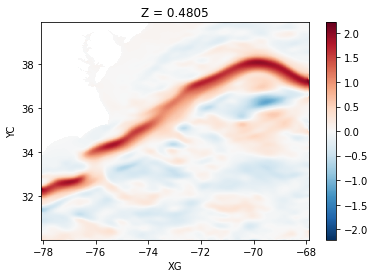

In [19]:
ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
ds_tmp['u'] = ds.U
ds_tmp['v'] = ds.V
ds_tmp['u'] = ds_tmp['u'].swap_dims({'XG':'XC'})
ds_tmp['v'] = ds_tmp['v'].swap_dims({'YG':'YC'})
(um, vm) = filter_30km_vector.apply_to_vector(ds_tmp.u.chunk({'YC':-1,'XC':-1}), 
                                       ds_tmp.v.chunk({'YC':-1,'XC':-1}), 
                                       dims=['YC','XC']
                                      )
um = um.swap_dims({'XC':'XG'})
vm = vm.swap_dims({'YC':'YG'})

um.isel(time=0,Z=0).plot()

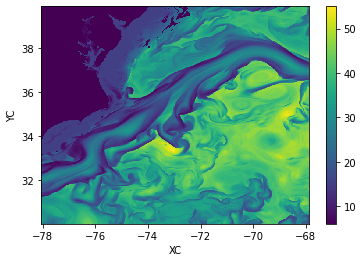

In [48]:
iz = (np.abs(ds.Z - np.abs(H))).argmin(dim="Z", skipna=True)
iz.where(H<0.).isel(time=0).plot()

In [20]:
# u_z = grid.interp(-grid.diff(um.chunk({'Z':-1}),'Z',boundary='extend'),
#                   'X',boundary='extend'
#                  ).where(grid.interp(ds.maskC.chunk({'Z':-1}),
#                                      'Z',boundary='extend')!=0.
#                         ).where(ds.Zp1<=np.abs(H)).sum('Zp1',skipna=True)
# v_z = grid.interp(-grid.diff(vm.chunk({'Z':-1}),'Z',boundary='extend'),
#                   'Y',boundary='extend'
#                  ).where(grid.interp(ds.maskC.chunk({'Z':-1}),
#                                      'Z',boundary='extend')!=0.
#                         ).where(ds.Zp1<=np.abs(H)).sum('Zp1',skipna=True)
u_z = grid.interp(um.isel(Z=0) - um.sel(Z=grid.interp(np.abs(H),'X',boundary='extend'),
                                        method='nearest'),
                  'X',boundary='extend'
                 ).where(ds.maskC.isel(Z=0)!=0.
                        ) / np.abs(H)
v_z = grid.interp(vm.isel(Z=0) - vm.sel(Z=grid.interp(np.abs(H),'Y',boundary='extend'),
                                        method='nearest'),
                  'Y',boundary='extend'
                 ).where(ds.maskC.isel(Z=0)!=0.
                        ) / np.abs(H)
U_z = np.sqrt(u_z**2 + v_z**2)
U_z

In [21]:
uu = (grid.interp(um,'X',boundary='extend'
                 ).where(ds.maskC!=0.).where(ds.Z<=np.abs(H))
      * dsi.e3t_0.data[np.newaxis]
     ).sum('Z',skipna=True) / np.abs(H)
     
vv = (grid.interp(vm,'Y',boundary='extend'
                 ).where(ds.maskC!=0.).where(ds.Z<=np.abs(H))
      * dsi.e3t_0.data[np.newaxis]
     ).sum('Z',skipna=True) / np.abs(H)
    
U = np.sqrt(uu**2 + vv**2)
U

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


,Array,Chunk
Bytes,316.55 MiB,273.75 kiB
Shape,"(89, 763, 611)","(3, 73, 160)"
Count,731574 Tasks,1680 Chunks
Type,float64,numpy.ndarray


In [22]:
h = (U / U_z).compute().chunk(ds.Q.chunks)
h

<xarray.DataArray (time: 89, YC: 763, XC: 611)>
dask.array<xarray-<this-array>, shape=(89, 763, 611), dtype=float64, chunksize=(1, 763, 611), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 30.01 30.02 30.04 30.05 ... 39.85 39.86 39.87 39.89
  * XC       (XC) float32 -78.06 -78.04 -78.02 -78.01 ... -67.93 -67.91 -67.9
    Z        float32 0.4805
Dimensions without coordinates: time

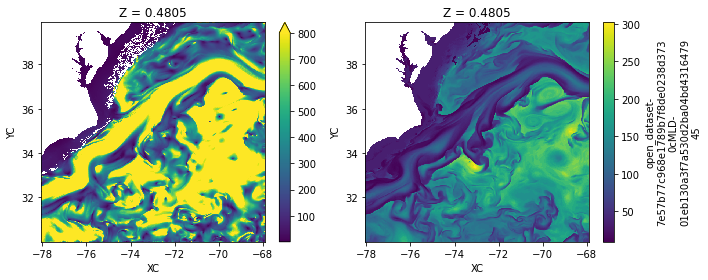

In [35]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
fig.set_tight_layout(True)

h.isel(time=0).plot(ax=ax1, vmax=800.)
H.where(ds.maskC.isel(Z=0)!=0.).isel(time=0).plot(ax=ax2)

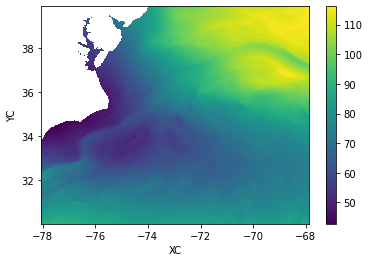

In [53]:
f = xr.apply_ufunc(gsw.f, xr.DataArray(dss.nav_lat.data, dims=['YC','XC'],
                                       coords={'YC':ds.YC,'XC':ds.XC}),
                   dask='parallelized'
                  )
hE = (.7*ustar / f)
hE.isel(time=0).plot()

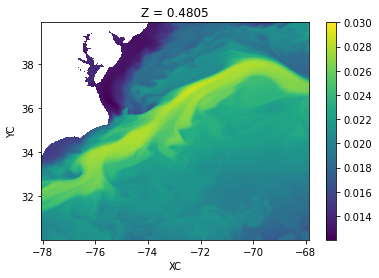

In [56]:
wstar = (-B0/hE)**(1/3)
wstar.isel(time=0).plot(vmax=.03)

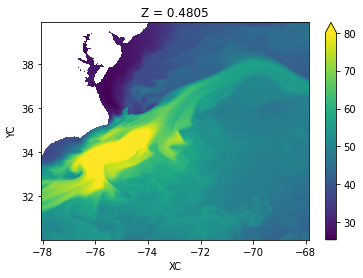

In [59]:
Cl = .25
mstar = .5
nstar = .066

Lf = Cl*(mstar*ustar**3 + nstar*wstar**3)**(2/3) / f**2 / hE
(Lf).isel(time=0).plot(vmax=80)

In [68]:
w_path = f'{SCRATCH}/region01/eNATL60/'+f'sigma0_fma.zarr'
sig0 = xr.open_zarr(gcs.get_mapper(w_path)).sig0

rho0 = 1e3
b = -xr.DataArray(sig0.isel(deptht=slice(None,-1)).data,
                  dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,
                          'YC':YC.data,
                          'XC':XC.data}
                 ).chunk({'Z':5}).where(ds.maskC!=0.) * grav / rho0
B = ((b.where(b.Z<=np.abs(H)) * dsi.e3t_0.data[np.newaxis]).sum('Z',skipna=True) 
      / np.abs(H))

/tmp/ipykernel_419/642536352.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  sig0 = xr.open_zarr(gcs.get_mapper(w_path)).sig0


In [95]:
area = xr.DataArray((dss.e1t * dss.e2t).data, dims=['YC','XC'],
                    coords={'YC':YC.data,
                            'XC':XC.data}
                   )

dxw = xr.DataArray(dss.e1u.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(dss.e2u.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(dss.e1v.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(dss.e2v.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # y-spacing centered at southern cell edge

dx_min = min(dss.e1u.min(['y','x']), dss.e2u.min(['y','x']),
             dss.e1v.min(['y','x']), dss.e2v.min(['y','x'])
            )
dx_min = dx_min.values

wet_mask = xr.DataArray(np.zeros_like(dss.sosstsst.isel(day=0)),
                        dims=['YC','XC'],
                        coords={'YC':YC.data,
                                'XC':XC.data}
           )
wet_mask[1:-1,1:-1] = dsi.tmask[0,1:-1,1:-1].data.astype(np.float64)

kappa_w = xr.zeros_like(wet_mask)
kappa_w[1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask)
kappa_s[1:-1,1:-1] += 1.

filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'YC':-1,'XC':-1}), 
        'dxw': dxw.chunk({'YC':-1,'XC':-1}), 'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
        'dxs': dxs.chunk({'YC':-1,'XC':-1}), 'dys': dys.chunk({'YC':-1,'XC':-1}), 
        'area': area.chunk({'YC':-1,'XC':-1}), 
        'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
        'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
    }
)

In [96]:
Bm = filter_30km.apply(B.chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])

In [97]:
B_x = grid.interp(grid.diff(Bm,'X',boundary='extend') 
                  / dss.e1u.data[np.newaxis],
                  'X',boundary='extend')
B_y = grid.interp(grid.diff(Bm,'Y',boundary='extend') 
                  / dss.e2v.data[np.newaxis],
                  'Y',boundary='extend')

In [98]:
Ce = .06
Psix = Ce/Lf/f * H**2 * B_y
Psiy = Ce/Lf/f * H**2 * (-B_x)
Psix

,Array,Chunk
Bytes,316.55 MiB,91.25 kiB
Shape,"(89, 763, 611)","(1, 73, 160)"
Count,498533 Tasks,4984 Chunks
Type,float64,numpy.ndarray


In [99]:
bff = Psix*B_y - Psiy*B_x
bff

,Array,Chunk
Bytes,316.55 MiB,91.25 kiB
Shape,"(89, 763, 611)","(1, 73, 160)"
Count,538886 Tasks,4984 Chunks
Type,float64,numpy.ndarray


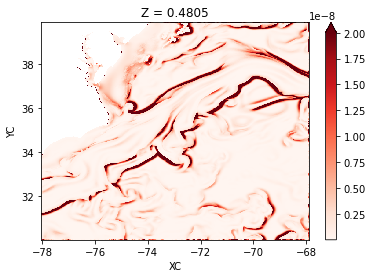

In [103]:
bff.isel(time=0)[1:-1,1:-1].plot(vmax=2e-8, cmap='Reds')